# GAN's consist of two networks playing an adversial game against each other
## Generator vs Discriminator
- Generator Produces fake data.
- Discriminator inspects the fake data and determines if its real or fake.
- Both of the above are trained simultaneously on random initalization.
- Thus, we need to minimize 2 losses i.e we use 2 optimizers.
- Then we use Binary Cross Entropy Loss
- Initially the generator might produce some noise, but after training a bit, it may come up with something that makes sense.
- After training even more, the generator is able to trick the discriminator into thinking that the generated fake data is real.

Installation

In [1]:
!pip install pytorch-lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl



Initializing Parameters

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count()) # To check the availability of the GPU's
NUM_WORKERS = int(os.cpu_count() / 2) # To check the number of working CPU 's


Making a Datamodule that inherits from Py torch lightning module.

This is used to create data loaders for training validation and test set.


In [4]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self,data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers
    # Transformation to convert images to tensors
    self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)) # The values here are mean and standard deviations from the MNIST dataset.
        ]
    )

  def prepare_data(self):
    MNIST(self.data_dir, train=True, download=True) # Download the training set
    MNIST(self.data_dir, train=False, download=True) # Download the testing set

  def setup(self,stage=None): # Setup function
    # Assigning training and validation datasets
    if stage == "fit" or stage is None:
      mnist_full = MNIST(self.data_dir,train = True, transform= self.transform)
      self.mnist_train,self.mnist_val = random_split(mnist_full,[55000,5000])
    # Assigning test dataset
    if stage == "test" or stage is None:
      self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

  def train_dataloader(self):
    return DataLoader(self.mnist_train,batch_size = self.batch_size,num_workers = self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)


Implementing the two networks (Generator and the Discriminator)

In [5]:
# Discriminator:
# Output: Fake or Real i.e 0 or 2
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    # We use CNN layers instead of normal linear layers
    # 2 Convolutional 2d layers
    self.conv1 = nn.Conv2d(1,10,kernel_size=5)
    self.conv2 = nn.Conv2d(10,20,kernel_size=5)
    # Dropout Layer
    self.conv2_drop = nn.Dropout2d()
    # 2 Normal Linear Layers
    self.fc1 = nn.Linear(320,50)
    self.fc2 = nn.Linear(50,1) # 1 because we need only 1 output
  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    # Flatten the tensor so it can be fed into the FC layers
    x = x.view(-1,320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x,training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [6]:
# Generate fake data: Output like real data (1, 28,28) and values -1, 1
class Generator(nn.Module):
  def __init__(self, latent_dim): # Latent dim. is a scaler value, which is used to upsample to an output which is of the shape of original images
    super().__init__()
    self.lin1 = nn.Linear(latent_dim, 7*7*64) # Linear Layer
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
    self.conv = nn.Conv2d(16,1,kernel_size=7) # Normal Convolution Layer

  def forward(self,x):
    # Pass the latent space input into linear layer and reshape it.
    x = self.lin1(x)
    x = F.relu(x)
    x = x.view(-1,64,7,7)
    # Upsampling (transposed conv) 16x16 (64 feature maps)
    x = self.ct1(x)
    x = F.relu(x)
    # Upsampling (transposed conv) 32x32 (16 feature maps)
    x = self.ct2(x)
    x = F.relu(x)
    # Convolution to 28x28 (1 feature map)
    return self.conv(x)

In [7]:
# Putting both these network together
# Putting both these network together
class GAN(pl.LightningModule):
  def __init__(self,latent_dim = 100, lr = 0.002):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()
    # Random Noise to test images
    self.validation_z = torch.randn(6,self.hparams.latent_dim)

    # Enable manual optimization
    self.automatic_optimization = False

  def forward(self,z):
    return self.generator(z)

  # Loss function
  def adversial_loss(self,y_hat,y):
    return F.binary_cross_entropy(y_hat,y)

  # Training step (inbuilt in pytorch)
  def training_step(self,batch,batch_idx): # Remove optimizer_idx
    opt_g, opt_d = self.optimizers() # Access optimizers

    real_imgs, _ = batch
    # Sample noise
    z = torch.randn(real_imgs.shape[0],self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # Train the generator
    opt_g.zero_grad() # Zero generator gradients
    fake_imgs = self(z)
    y_hat = self.discriminator(fake_imgs)
    y = torch.ones(real_imgs.size(0),1)
    y = y.type_as(real_imgs)
    g_loss = self.adversial_loss(y_hat,y)
    self.manual_backward(g_loss) # Manually backpropagate generator loss
    opt_g.step() # Update generator weights

    # Train the disriminator
    opt_d.zero_grad() # Zero discriminator gradients
    # How good can it label as real
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0),1)
    y_real = y_real.type_as(real_imgs)
    real_loss = self.adversial_loss(y_hat_real,y_real)
    # How good can it label as fake
    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_imgs.size(0),1)
    y_fake = y_fake.type_as(real_imgs)
    fake_loss = self.adversial_loss(y_hat_fake,y_fake)
    # Total discriminator loss
    d_loss = (real_loss+fake_loss)
    self.manual_backward(d_loss) # Manually backpropagate discriminator loss
    opt_d.step() # Update discriminator weights

    # Log losses
    log_dict = {"g_loss":g_loss, "d_loss":d_loss}
    return {"loss":d_loss,"progress_bar":log_dict,"log":log_dict}

  # Configure
  def configure_optimizers(self):
    lr = self.hparams.lr
    # 2 optimizers, 1 for gen. and 1 for discriminator
    opt_g = torch.optim.Adam(self.generator.parameters(),lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(),lr=lr)
    return [opt_g,opt_d],[]

  # To see what our fake data looks like
  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()
    print('epoch',self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach().numpy()[i,0,:,:],cmap='gray_r',interpolation='none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
    plt.show()
  # To show images at the end of epoch only.
  def on_epoch_end(self):
    self.plot_imgs()
  def evaluate_gan(self):
        # Evaluate the GAN by generating some images and plotting them
        z = torch.randn(16, self.hparams.latent_dim).type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        fig = plt.figure(figsize=(8, 8))
        for i in range(sample_imgs.size(0)):
            plt.subplot(4, 4, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach().numpy()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
        plt.show()

In [8]:
data_module = MNISTDataModule()
model = GAN()


Here we have the first generated images, which is basically just noise (which is expected at the initial steps of training)

epoch 0


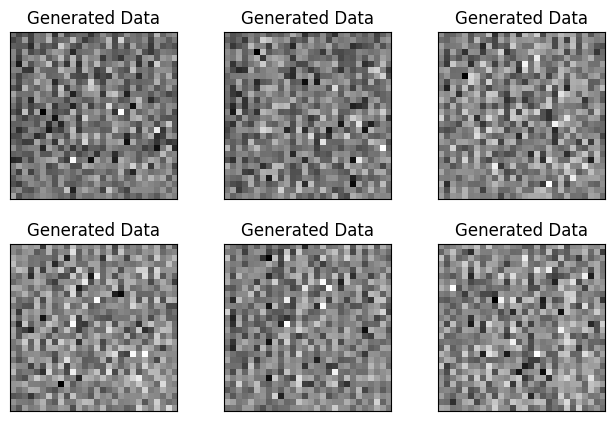

In [9]:
model.plot_imgs()

In [10]:
class GenerateAndShowImagesCallback(pl.Callback):
    def __init__(self, num_images=6):
        self.num_images = num_images

    def on_epoch_end(self, trainer, pl_module):
        z = torch.randn(self.num_images, pl_module.hparams.latent_dim, 1, 1, device=pl_module.device)
        generated_imgs = pl_module(z)
        generated_imgs = generated_imgs.cpu().detach()

        fig, axes = plt.subplots(1, self.num_images, figsize=(15, 5))
        for img, ax in zip(generated_imgs, axes):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')

        plt.show()


In [11]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    enable_progress_bar=True,
    callbacks=[GenerateAndShowImagesCallback(num_images=6)]
)

trainer.fit(model,data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11756277.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343259.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 908788.50it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9398386.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
